In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 9s - loss: 0.1430

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 5s 587ms/step - loss: 0.1116
Average validation loss: 0.6787472367286682
4/4 [==============================] - 5s 597ms/step - loss: 0.1116 - val_loss: 0.6787
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 7s 578ms/step - loss: 0.0793 - val_loss: 0.6787
Average validation loss: 0.5022004246711731
4/4 [==============================] - 7s 589ms/step - loss: 0.0793 - val_loss: 0.5905
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 10s 599ms/step - loss: 0.0605 - val_loss: 0.5905
Average validation loss: 0.4490463137626648
4/4 [==============================] - 10s 611ms/step - loss: 0.0605 - val_loss: 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 700ms/step - loss: 6.0022e-05
Average validation loss: 1.041200792251118e-09
8/8 [==============================] - 6s 710ms/step - loss: 6.0022e-05 - val_loss: 1.0412e-09
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 707ms/step - loss: 5.8490e-05 - val_loss: 1.0412e-09
Average validation loss: 7.721723038756068e-09
8/8 [==============================] - 11s 717ms/step - loss: 5.8490e-05 - val_loss: 4.3815e-09
Epoch 3/10
8/8 [==============================] - 17s 710ms/step - loss: 5.7211e-05 - val_loss: 4.3815e-09
Average validation loss: 0.00013261464846436866
8/8 [==============================] - 17s 724ms/step - loss: 5.7211e-05 - val_loss: 4.4208e-05
Epoch 4/10
8/8 [==============================] - 23s 693ms/step - loss: 5.6048e-05 - val_loss: 4.4208e-05
Ave

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 727ms/step - loss: 1.5429e-04
Average validation loss: 0.13394913040451684
12/12 [==============================] - 9s 738ms/step - loss: 1.5429e-04 - val_loss: 0.1339
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 724ms/step - loss: 1.6234e-04 - val_loss: 0.1339
Average validation loss: 0.10675588089668508
12/12 [==============================] - 18s 734ms/step - loss: 1.6234e-04 - val_loss: 0.1204
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 701ms/step - loss: 1.6147e-04 - val_loss: 0.1204
Average validation loss: 0.03350155365963777
12/12 [==============================] - 26s

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 726ms/step - loss: 9.4442e-05
Average validation loss: 0.08949953101241803
16/16 [==============================] - 12s 737ms/step - loss: 9.4442e-05 - val_loss: 0.0895
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 729ms/step - loss: 8.9036e-05 - val_loss: 0.0895
Average validation loss: 0.05530813693849268
16/16 [==============================] - 24s 739ms/step - loss: 8.9036e-05 - val_loss: 0.0724
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 35s 696ms/step - loss: 8.5333e-05 - val_loss: 0.0724
Average validation loss: 0.04162667485434213
16/16 [==============================] - 3

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 712ms/step - loss: 3.8205e-05
Average validation loss: 0.056444305047625674
20/20 [==============================] - 15s 724ms/step - loss: 3.8205e-05 - val_loss: 0.0564
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 725ms/step - loss: 4.0135e-05 - val_loss: 0.0564
Average validation loss: 0.06214195825523348
20/20 [==============================] - 29s 735ms/step - loss: 4.0135e-05 - val_loss: 0.0593
Epoch 3/10
20/20 [==============================] - 44s 712ms/step - loss: 3.6729e-05 - val_loss: 0.0593
Average validation loss: 0.027109756600111723
20/20 [==============================] - 44s 724ms/step - loss: 3.6729e-05 - val_loss: 0.0486
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/wei

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 18s 726ms/step - loss: 1.0334e-04
Average validation loss: 0.03204733102271954
24/24 [==============================] - 18s 736ms/step - loss: 1.0334e-04 - val_loss: 0.0320
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 735ms/step - loss: 8.0388e-05 - val_loss: 0.0320
Average validation loss: 0.044761123756567635
24/24 [==============================] - 36s 744ms/step - loss: 8.0388e-05 - val_loss: 0.0384
Epoch 3/10
24/24 [==============================] - 53s 723ms/step - loss: 6.6165e-05 - val_loss: 0.0384
Average validation loss: 0.05345792261262735
24/24 [==============================] - 53s 733ms/step - loss: 6.6165e-05 - val_loss: 0.0434
Epoch 4/10
24/24 [==============================] - 70s 712ms/step - loss: 5.6249e-05 - val_loss: 0.0434
Average validatio

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 714ms/step - loss: 1.4411e-04
Average validation loss: 0.043905772361904384
40/40 [==============================] - 29s 725ms/step - loss: 1.4411e-04 - val_loss: 0.0439
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 720ms/step - loss: 1.1451e-04 - val_loss: 0.0439
Average validation loss: 0.030897552333772182
40/40 [==============================] - 58s 729ms/step - loss: 1.1451e-04 - val_loss: 0.0374
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 87s 711ms/step - loss: 9.8462e-05 - val_loss: 0.0374
Average validation loss: 0.05078403651714325
40/40 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 33s 687ms/step - loss: 7.8976e-05
Average validation loss: 0.01204538830400755
48/48 [==============================] - 33s 697ms/step - loss: 7.8976e-05 - val_loss: 0.0120
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 66s 682ms/step - loss: 5.4134e-05 - val_loss: 0.0120
Average validation loss: 0.011216503762019178
48/48 [==============================] - 67s 692ms/step - loss: 5.4134e-05 - val_loss: 0.0116
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 101s 706ms/step - loss: 4.2188e-05 - val_loss: 0.0116
Average validation loss: 0.009667415141545158
48/48 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 716ms/step - loss: 8.3787e-05
Average validation loss: 0.014064144380556951
56/56 [==============================] - 41s 727ms/step - loss: 8.3787e-05 - val_loss: 0.0141
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 81s 716ms/step - loss: 6.2835e-05 - val_loss: 0.0141
Average validation loss: 0.014055069171133385
56/56 [==============================] - 82s 726ms/step - loss: 6.2835e-05 - val_loss: 0.0141
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 122s 718ms/step - loss: 4.7929e-05 - val_loss: 0.0141
Average validation loss: 0.015607353349228756
56/56 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 725ms/step - loss: 5.0566e-05
Average validation loss: 0.03354788438809919
64/64 [==============================] - 47s 736ms/step - loss: 5.0566e-05 - val_loss: 0.0335
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 712ms/step - loss: 3.5468e-05 - val_loss: 0.0335
Average validation loss: 0.017182440709120783
64/64 [==============================] - 93s 722ms/step - loss: 3.5468e-05 - val_loss: 0.0254
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 139s 714ms/step - loss: 2.7936e-05 - val_loss: 0.0254
Average validation loss: 0.039189527522694334
64/64 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 722ms/step - loss: 5.3887e-05
Average validation loss: 0.011430672085326578
72/72 [==============================] - 53s 732ms/step - loss: 5.3887e-05 - val_loss: 0.0114
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 711ms/step - loss: 3.8866e-05 - val_loss: 0.0114
Average validation loss: 0.012915532208151288
72/72 [==============================] - 105s 721ms/step - loss: 3.8866e-05 - val_loss: 0.0122
Epoch 3/10
72/72 [==============================] - 156s 710ms/step - loss: 2.9771e-05 - val_loss: 0.0122
Average validation loss: 0.010919025736964412
72/72 [==============================] - 157s 720ms/step - loss: 2.9771e-05 - val_loss: 0.0118
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_061

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 719ms/step - loss: 4.0399e-05
Average validation loss: 0.010188160021789372
80/80 [==============================] - 58s 729ms/step - loss: 4.0399e-05 - val_loss: 0.0102
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 723ms/step - loss: 2.6974e-05 - val_loss: 0.0102
Average validation loss: 0.00879185099620372
80/80 [==============================] - 117s 733ms/step - loss: 2.6974e-05 - val_loss: 0.0095
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 175s 721ms/step - loss: 2.2538e-05 - val_loss: 0.0095
Average validation loss: 0.00897613971028477
80/80 [=============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 721ms/step - loss: 8.5629e-05
Average validation loss: 0.01916093243441234
96/96 [==============================] - 70s 731ms/step - loss: 8.5629e-05 - val_loss: 0.0192
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 139s 715ms/step - loss: 5.3408e-05 - val_loss: 0.0192
Average validation loss: 0.020761699124705046
96/96 [==============================] - 140s 725ms/step - loss: 5.3408e-05 - val_loss: 0.0200
Epoch 3/10
96/96 [==============================] - 209s 724ms/step - loss: 3.9236e-05 - val_loss: 0.0200
Average validation loss: 0.025242884575466935
96/96 [==============================] - 210s 734ms/step - loss: 3.9236e-05 - val_loss: 0.0217
Epoch 4/10
96/96 [==============================] - 279s 717ms/step - loss: 3.1891e-05 - val_loss: 0.0217
Average va

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 718ms/step - loss: 4.2134e-05
Average validation loss: 0.014931366921518929
120/120 [==============================] - 87s 729ms/step - loss: 4.2134e-05 - val_loss: 0.0149
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 723ms/step - loss: 2.8661e-05 - val_loss: 0.0149
Average validation loss: 0.010390332370297984
120/120 [==============================] - 175s 733ms/step - loss: 2.8661e-05 - val_loss: 0.0127
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 262s 720ms/step - loss: 2.1636e-05 - val_loss: 0.0127
Average validation loss: 0.009583267128133836
120/120 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 716ms/step - loss: 3.9214e-05
Average validation loss: 0.02077942225393296
144/144 [==============================] - 104s 726ms/step - loss: 3.9214e-05 - val_loss: 0.0208
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 208s 718ms/step - loss: 2.8761e-05 - val_loss: 0.0208
Average validation loss: 0.010117557097045291
144/144 [==============================] - 209s 728ms/step - loss: 2.8761e-05 - val_loss: 0.0154
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 312s 714ms/step - loss: 2.2457e-05 - val_loss: 0.0154
Average validation loss: 0.021190086701911543
144/144 [==============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 716ms/step - loss: 1.9543e-05
Average validation loss: 0.014750800759429694
160/160 [==============================] - 116s 726ms/step - loss: 1.9543e-05 - val_loss: 0.0148
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 231s 720ms/step - loss: 1.4745e-05 - val_loss: 0.0148
Average validation loss: 0.008195104843980516
160/160 [==============================] - 233s 730ms/step - loss: 1.4745e-05 - val_loss: 0.0115
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 348s 718ms/step - loss: 1.2500e-05 - val_loss: 0.0115
Average validation loss: 0.009098490939140901
160/160 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 717ms/step - loss: 6.8623e-05
Average validation loss: 0.013028411470586435
200/200 [==============================] - 145s 727ms/step - loss: 6.8623e-05 - val_loss: 0.0130
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 289s 719ms/step - loss: 4.6184e-05 - val_loss: 0.0130
Average validation loss: 0.009452663895208388
200/200 [==============================] - 291s 729ms/step - loss: 4.6184e-05 - val_loss: 0.0112
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 434s 716ms/step - loss: 3.5185e-05 - val_loss: 0.0112
Average validation loss: 0.009121634882176296
200/200 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:38 - loss: 9.9952e-07

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 168s 698ms/step - loss: 3.0256e-05
Average validation loss: 0.019341656408505513
240/240 [==============================] - 170s 708ms/step - loss: 3.0256e-05 - val_loss: 0.0193
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 337s 697ms/step - loss: 2.1395e-05 - val_loss: 0.0193
Average validation loss: 0.01455236506590154
240/240 [==============================] - 339s 706ms/step - loss: 2.1395e-05 - val_loss: 0.0169
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 506s 694ms/step - loss: 1.7111e-05 - val_loss: 0.0169
Average validation loss: 0.009528813512345854
240/240 [==============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.08080336127177816, 0.06858999399650859, 0.1062127215603159, 0.03638417684189612, 0.025921694917945385, 0.021556853085542876, 0.02424870313046608, 0.026404166930724577, 0.026657990461604907, 0.02127920178538458, 0.011973194924670093, 0.012596508770595392, 0.015979716470774293, 0.012376713585787891, 0.01273796298221416, 0.008991470355267893, 0.01702334243977166, 0.016213037659244353]
std_val_losses =  [0.14571033001437536, 0.0838412692504612, 0.13784187484470084, 0.02384659056810962, 0.014729206780721274, 0.018590497850989793, 0.02068035575243564, 0.02456419545510241, 0.026231490547547302, 0.022302442927900606, 0.010626019475187569, 0.02155736183737718, 0.01307089182454897, 0.009229668584645755, 0.01056092717106301, 0.006786079058356636, 0.016764604721022567, 0.02374164749104778]


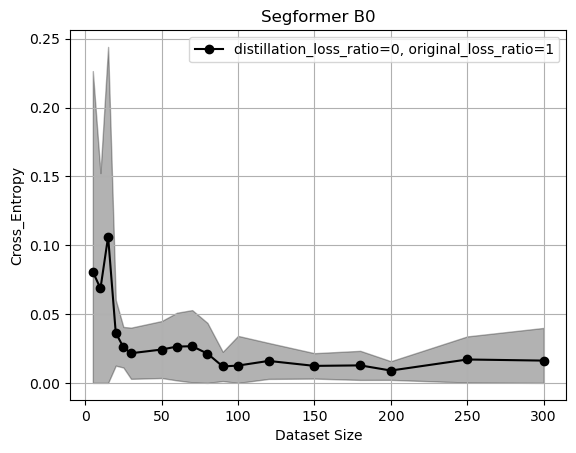

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()